In [1]:
import FileIO
using Colors
import Statistics

┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/FileIO/6iKRU.ji for FileIO [5789e2e9-d7fb-5bc7-8068-2c6fae9b9549]
└ @ Base loading.jl:1190
┌ Warning: Replacing docs for `FileIO.filename :: Tuple{Any}` in module `FileIO`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `FileIO.file_extension :: Tuple{Any}` in module `FileIO`
└ @ Base.Docs docs/Docs.jl:223


In [2]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry

┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/XMLDict/B68CN.ji for XMLDict [228000da-037f-5747-90a9-8195ccbf91a5]
└ @ Base loading.jl:1190


In [3]:
master_data_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
master_meta_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/annotation/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.xml"
master_pod_path  = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"

slave_data_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/measurement/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.tiff"
slave_meta_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/annotation/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.xml"
slave_pod_path = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170416T111343_V20170326T225942_20170328T005942.EOF"


dem_path = "/Users/simon/Data/DEM/srtm_38_01/srtm_38_01_transformed.tif"

"/Users/simon/Data/DEM/srtm_38_01/srtm_38_01_transformed.tif"

┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1190


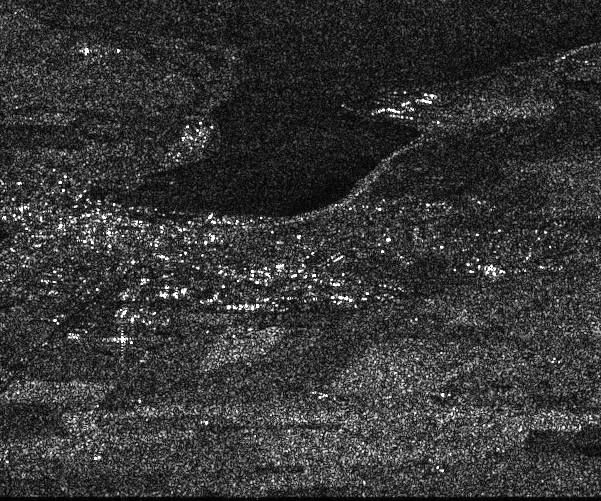

In [4]:
master_view = [1000:1500,5900:6500]
master_data = Load.slc_data(master_data_path,master_view)
SlcUtil.show_img(master_data,0.995)

In [5]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [6]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

In [7]:
lut = look_up_table(master_view,meta,precise_orbit,dem)

Dict{String,Any} with 7 entries:
  "slave_line"    => [1000.17, 1001.17, 1002.17, 1003.17, 1004.17, 1005.17, 100…
  "master_sample" => [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 590…
  "latitude"      => [56.5764, 56.5763, 56.5762, 56.576, 56.5759, 56.5758, 56.5…
  "heights"       => [51.5666, 52.713, 53.8594, 55.0058, 56.1776, 57.368, 58.55…
  "master_line"   => [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 100…
  "longitude"     => [8.32236, 8.3223, 8.32224, 8.32219, 8.32213, 8.32207, 8.32…
  "slave_sample"  => [5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 588…

## Resample

In [8]:
dim = (length(master_view[1]),length(master_view[2]))

(501, 601)

### load slave image data

In [9]:
padd = 2

slave_view = round(Int,minimum(lut["slave_line"])-padd): round(Int,maximum(lut["slave_line"])+padd),
            round(Int,minimum(lut["slave_sample"])-padd): round(Int,maximum(lut["slave_sample"])+padd)
slave_data = Load.slc_data(slave_data_path,slave_view);

In [10]:
slave_resample = Misc.interp(Misc.flatten(slave_view[1],slave_view[2],slave_data)..., lut["slave_line"], lut["slave_sample"])
slave_resample = reshape(slave_resample, dim);

In [11]:
inferogram = master_data .* conj.(slave_resample);

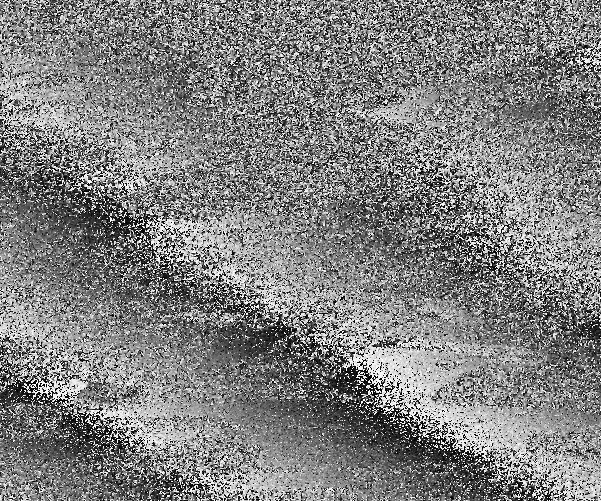

In [12]:
Gray.((angle.(inferogram) .+pi)./(2*pi))

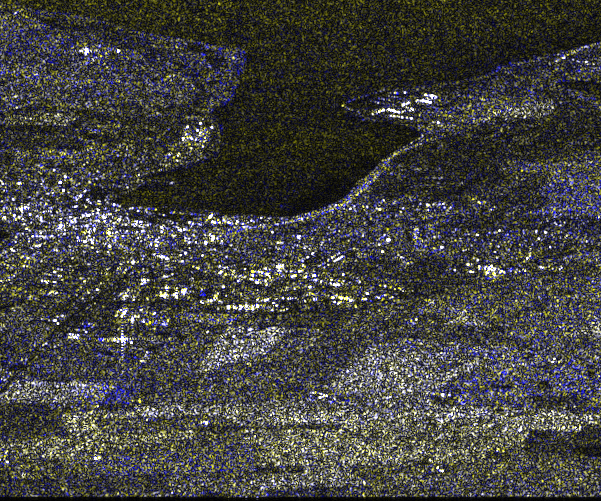

In [13]:
max_quantile = 0.99
temp_master = abs.(master_data)./Statistics.quantile(reshape(abs.(master_data), :), max_quantile)
temp_slave = abs.(slave_resample)./Statistics.quantile(reshape(abs.(slave_resample), :), max_quantile);
temp_master[temp_master .> 1] .= 1
temp_slave[temp_slave .> 1] .= 1

color_img = RGB{Float32}.(temp_master,temp_master,temp_slave)

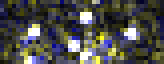

In [14]:
show_lines = 1120-master_view[1].start : 1135-master_view[1].start
show_samples = 6080-master_view[2].start : 6120-master_view[2].start
color_img[show_lines,show_samples]

In [15]:
FileIO.save("resample.jpg", color_img[show_lines,show_samples])